# Assignment 1 (STDSR)
#### Feygelman Andrey

# 1. Implementation

### Imports

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from collections import namedtuple

### Some complementary functions

In [ ]:
def floor(x):
    return int(np.floor(x))

def ceil(x):
    return int(np.ceil(x))

### The GK01 model itself
I have no idea how it works
I just took the pseudo-code from the paper 
(Greenwald, M., & Khanna, S. (2001). Space-efficient online computation of quantile summaries. ACM SIGMOD Record, 30(2), 58-66.)

In [217]:
from functools import lru_cache

class GK01:
    # The Summaries
    @dataclass(order = True)
    class S:
        v: float
        g: int = field(compare = False)
        delta: int = field(compare = False)
        
        
    def __init__(self, epsilon = 0.05):
        self.epsilon = epsilon
        self.data: list[S] = []
        self.n = 0
        self.s = 0
        self.compress_each = floor(1/(2*epsilon))
    
    
    def add_all(self, dataset):
        for v in dataset:
            self.add(v)
        return self
    
    
    def add(self, v):
        if (self.n % self.compress_each == 0):
            self._compress()
        
        self._insert(v)
        self.n += 1
        assert len(self.data) == self.s
        return self
        
        
    def quantile(self, q):
        sum_of_g = 0
        for i in range(self.s):
            sum_of_g += self.data[i].g
            r = ceil(q*self.n)
            en = self.epsilon * self.n
            if (r - sum_of_g <= en and sum_of_g + self.data[i].delta - r <= en):
                return self.data[i].v
            
        return self.data[0].v # It is not clear from the paper but I guess i should return here the 0th element. idk why, but it works
    
    def internal_cdf(self, steps = 50):
        # just a complementary function for nice graphs
        # maybe would've been better to make this as an external function. Maybe, maybe
        y = []
        x = np.linspace(0,1, steps)
        for q in x:
            y.append(self.quantile(q))
        return x, y
    
    def _insert(self, v):
        data = self.data
        S = self.S
        
        if (self.s == 0):
            data.append(S(v, 1, 0))
        else:
            t = S(v, 1, floor(2*self.epsilon*self.n))
            if (t < data[0]): 
                data.insert(0, t)
            elif (t > data[-1]):
                data.append(t)
            else:
                for i in range(1, len(data)):
                    if (data[i-1] < t <= data[i]):
                        data.insert(i, t)
        self.s += 1
    
    def _compress(self):
        band = self._band
        data = self.data
        
        def find_children(i):
            found = []
            max_ = -1
            our_band = band(data[i].delta)
            for j in range(0, i, -1):
                j_band = band(data[j].delta) # variable naming is hard
                if (j_band >= our_band): return found
                if (j_band > max_): return found
                max_ = j_band
                found.append(j)
            return found
                
        
        for i in range(self.s-2, -1, -1):
            if (not band(data[i].delta) <= band(data[i+1].delta)): continue
            family = [i] + find_children(i) # family = node and all its descendants; variable naming is hard((
#             print(i, family)
            g_star = sum(data[j].g for j in family)
            
            if (g_star + data[i+1].g + data[i+1].delta < 2*self.epsilon*self.n): 
                for e in family: 
                    self._delete(e)
    
    def _delete(self, i):
        self.data[i+1].g += self.data[i].g
        self.data.pop(i)
        self.s -= 1
    
    def _band(self, delta):
        return self._band2(delta, self.n)
    
    # lru_cache is here to speed up band function
    @lru_cache
    def _band2(self, delta, n):
        p = int(np.floor(2*self.epsilon*n))
        a = 1
        while(True):
            if (delta> p - 2**a - p%2**a): return a
            a += 1
            

# 2. Simulations

## 2.1 Space complexity
The main assumption of the algorithm is that space complexity is O($1/\epsilon\ log(\epsilon n)$) 

Specifically number of tuples is at most $(11/2\epsilon)\ log(2\epsilon n)$

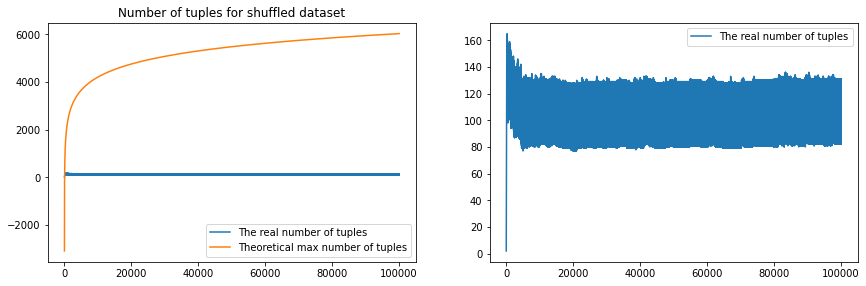

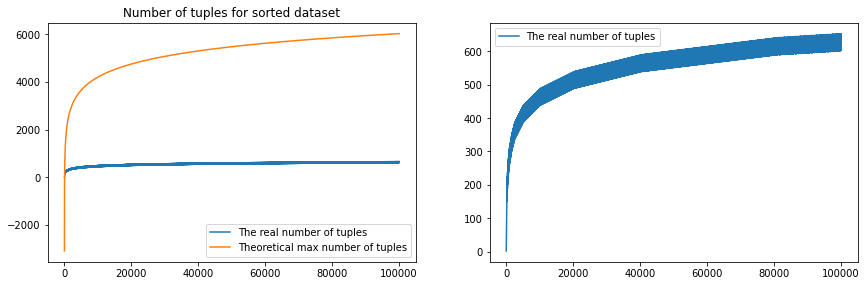

In [303]:
n = 10**5
epsilon = 0.01

# shuffle dataset
dataset = np.array(range(0, n))
np.random.shuffle(dataset)
model = GK01(epsilon)
y = []
ideal = [11/(2*epsilon)*np.log2(2*epsilon*n) for n in range(1, len(dataset))]

for e in dataset:
    model.add(e)
    y.append(len(model.data))

y.pop(0)
plt.subplots_adjust(hspace=1,right=2,bottom=0.05)
plt.subplot(1,2,1)
plt.plot(y, label = 'The real number of tuples')
plt.plot(ideal, label = 'Theoretical max number of tuples')
plt.legend()
plt.title('Number of tuples for shuffled dataset')

plt.subplot(1,2,2)
plt.plot(y, label = 'The real number of tuples')
plt.legend()
plt.show()

# sorted dataset
dataset = np.array(range(0, n))
model = GK01(epsilon)
y = []
ideal = [11/(2*epsilon)*np.log2(2*epsilon*n) for n in range(1, len(dataset))]

for e in dataset:
    model.add(e)
    y.append(len(model.data))

y.pop(0)
plt.subplots_adjust(hspace=1,right=2,bottom=0.05)
plt.subplot(1,2,1)
plt.plot(y, label = 'The real number of tuples')
plt.plot(ideal, label = 'Theoretical max number of tuples')
plt.legend()
plt.title('Number of tuples for sorted dataset')
plt.subplot(1,2,2)
plt.plot(y, label = 'The real number of tuples')
plt.legend()
plt.show()

### As we can see, the number of tuples (and space complexity) indeed stay below theoretical line and grows like logarithm of N

### Now let's see how space usage depends on epsilon

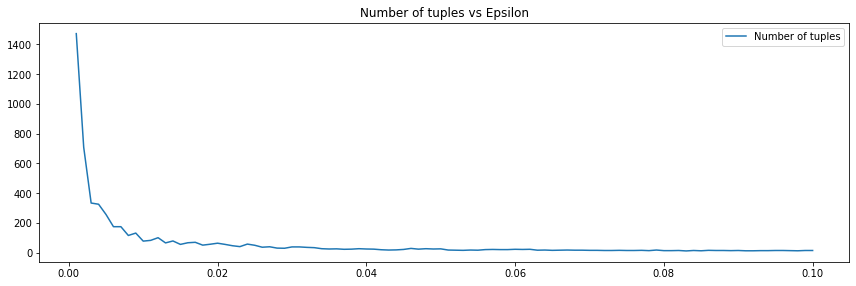

In [318]:
epsilons = np.linspace(0.001, 0.1, 100)
y = []
n = 10**4
for e in epsilons:
    dataset = np.array(range(0, n))
    np.random.shuffle(dataset)
    model = GK01(e).add_all(dataset)
    y.append(len(model.data))
    
plt.subplots_adjust(hspace=1,right=2,bottom=0.05)
plt.plot(epsilons, y, label = 'Number of tuples')
plt.title('Number of tuples vs Epsilon')
plt.legend()
None

### Indeed! The space usage grows as epsilon getting closer to 0

## 2.2 Accuracy
The accuracy-space trade-off is determant by epsilon

To demostrate the accuracy in a visual way, I will plot and compare the real cdf of the dataset and the one stored in the model

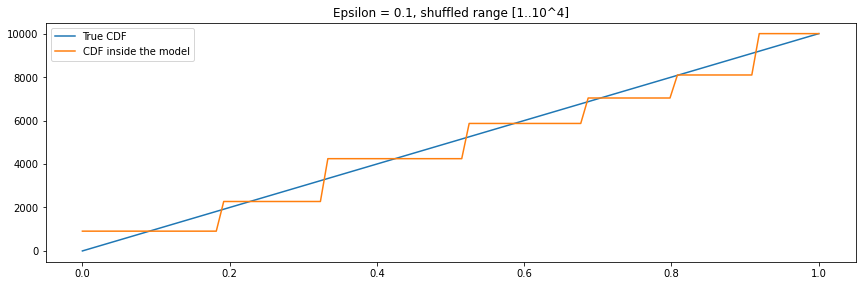

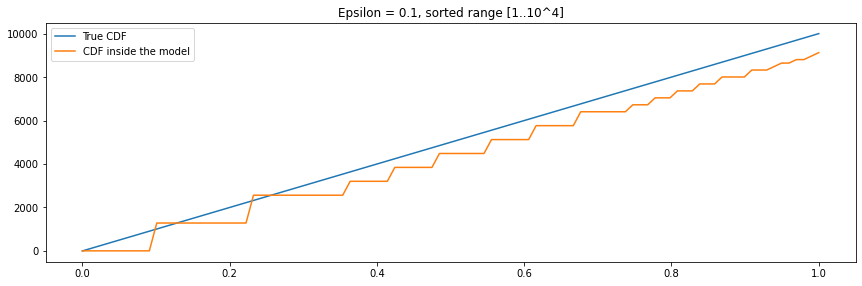

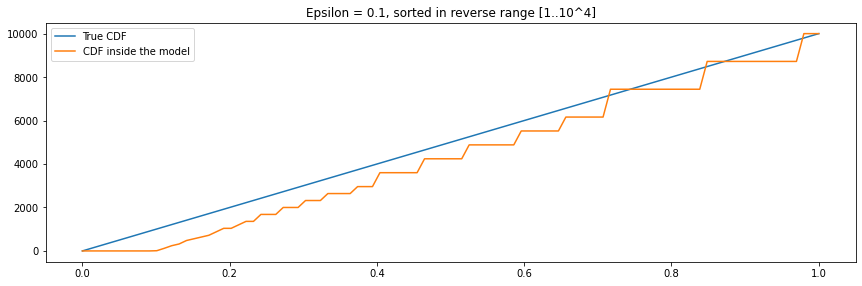

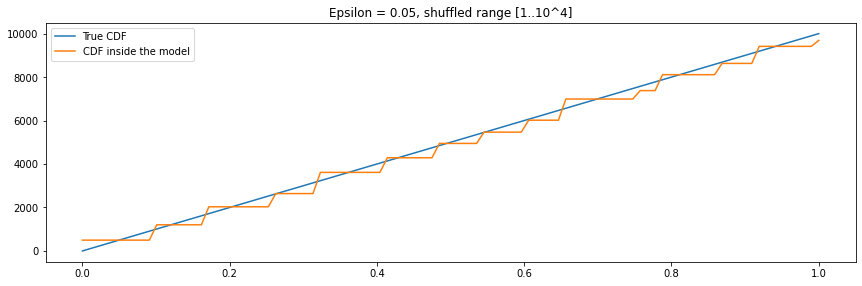

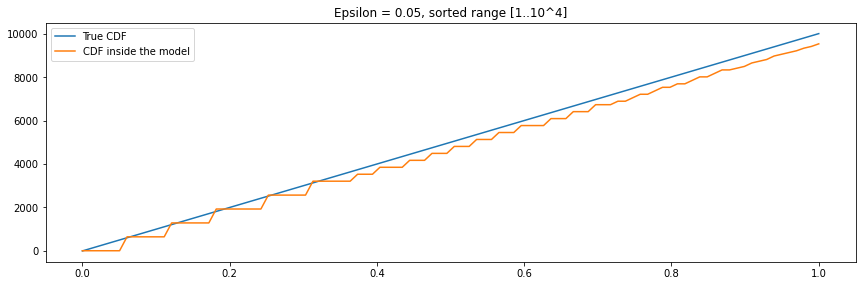

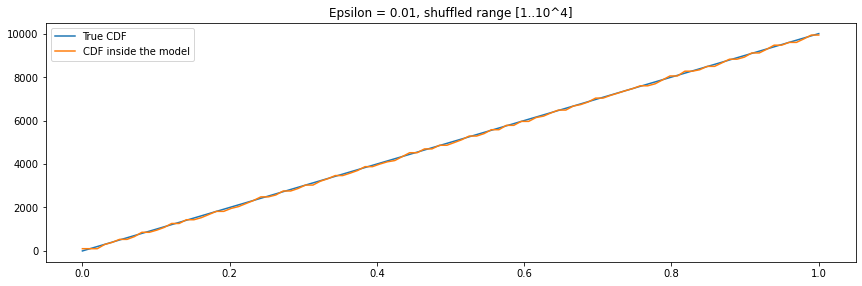

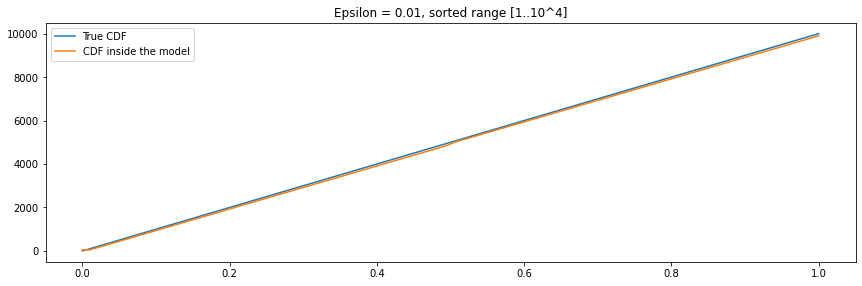

In [308]:
def do(epsilon, dataset, title = '', steps = 100):
    model = model = GK01(epsilon).add_all(dataset)
    x = np.linspace(0,1, steps)
    y = [np.quantile(dataset, q) for q in x]
    y_pred = model.internal_cdf(steps)
    plt.subplots_adjust(hspace=1,right=2,bottom=0.05)
    plt.plot(x, y, label = 'True CDF')
    plt.plot(*y_pred, label = 'CDF inside the model')
    plt.title(f'Epsilon = {epsilon}, '+ title)
    plt.legend()
    plt.show()


dataset = np.array(range(0, 10**4))
np.random.shuffle(dataset)
do(0.1, dataset, 'shuffled range [1..10^4]')

dataset = np.array(range(0, 10**4))
do(0.1, dataset, 'sorted range [1..10^4]')

dataset = np.array(range(0, 10**4))[::-1]
do(0.1, dataset, 'sorted in reverse range [1..10^4]')

dataset = np.array(range(0, 10**4))
np.random.shuffle(dataset)
do(0.05, dataset, 'shuffled range [1..10^4]')

dataset = np.array(range(0, 10**4))
do(0.05, dataset, 'sorted range [1..10^4]')

dataset = np.array(range(0, 10**4))
np.random.shuffle(dataset)
do(0.01, dataset, 'shuffled range [1..10^4]')

dataset = np.array(range(0, 10**4))
do(0.01, dataset, 'sorted range [1..10^4]')

### As we can see, the accuracy is indeed grows when epsilon decreases
Also we see that if we give a model a sorted dataset, it will start to forget older values to save space

The model works best if values are comming in more or less random order

### Now let's try different distributions

### Power 4 distribution:

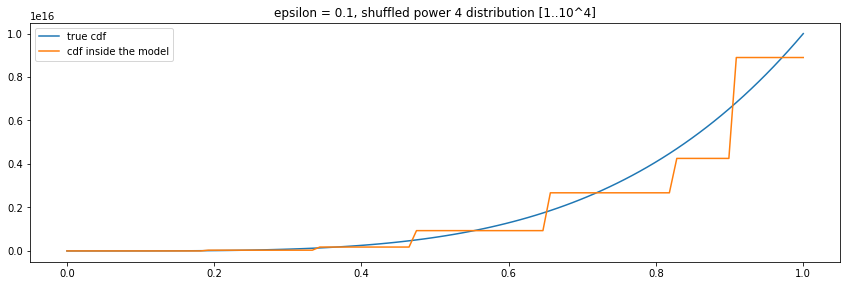

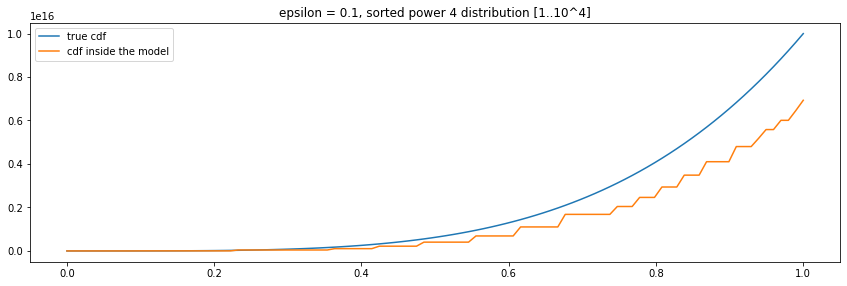

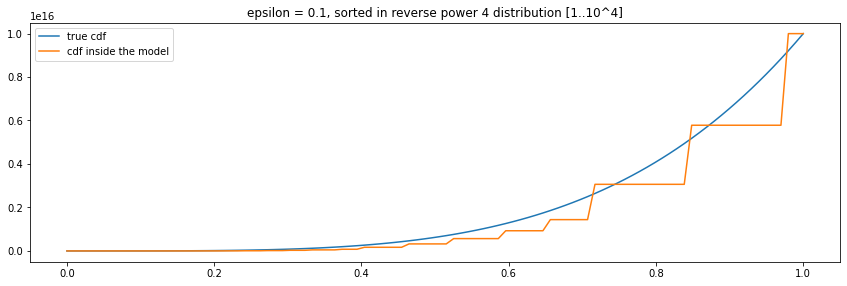

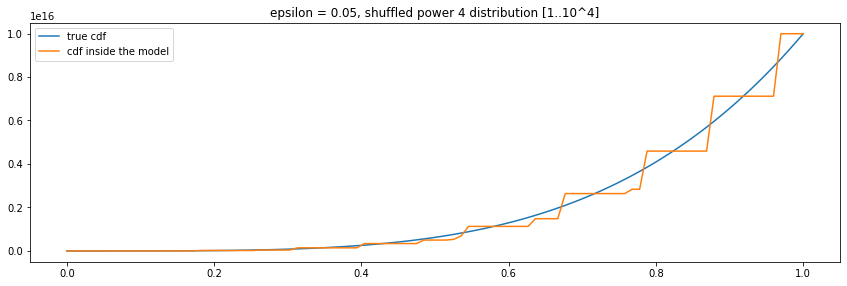

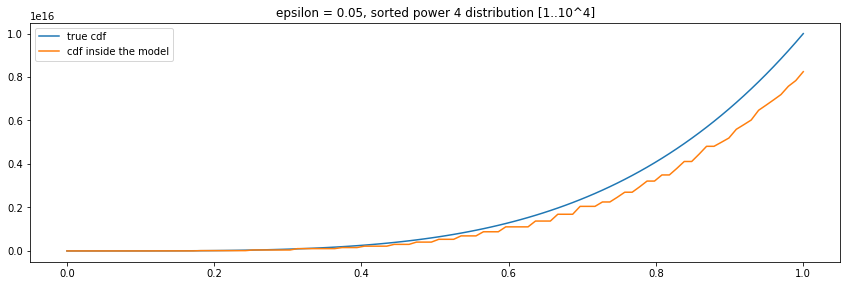

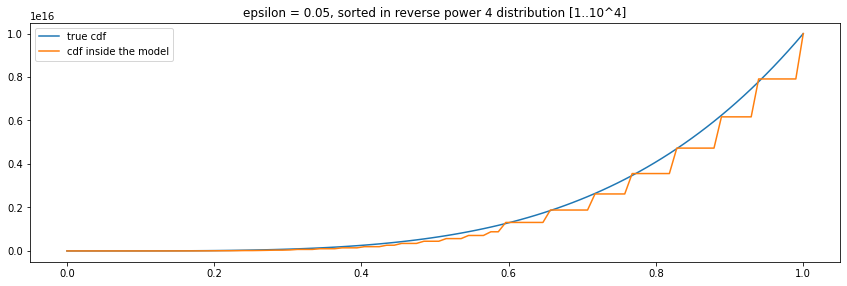

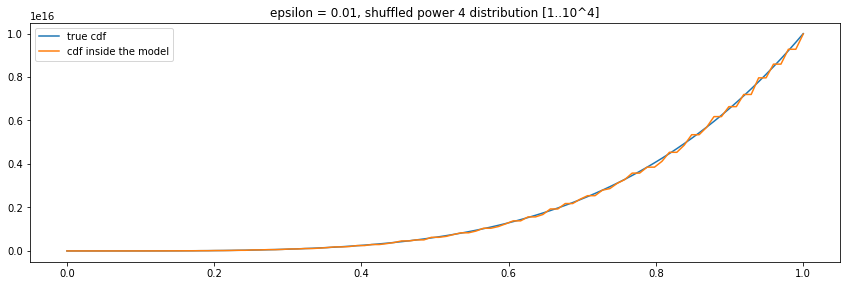

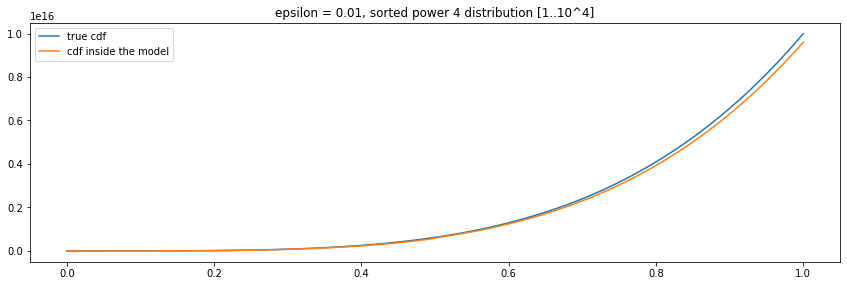

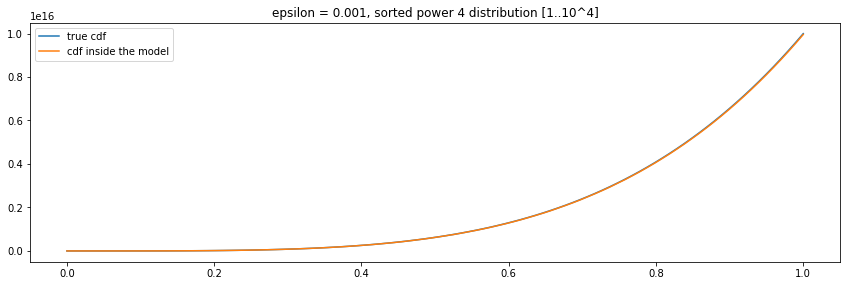

In [302]:
n = 4

dataset = np.array([x**4 for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.1, dataset, f'shuffled power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
do(0.1, dataset, f'sorted power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])[::-1]
do(0.1, dataset, f'sorted in reverse power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.05, dataset, f'shuffled power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
do(0.05, dataset, f'sorted power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])[::-1]
do(0.05, dataset, f'sorted in reverse power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.01, dataset, f'shuffled power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
do(0.01, dataset, f'sorted power 4 distribution [1..10^{n}]')

dataset = np.array([x**4 for x in range(0, 10**n)])
do(0.001, dataset, f'sorted power 4 distribution [1..10^{n}]')

### Cubic root distribution:

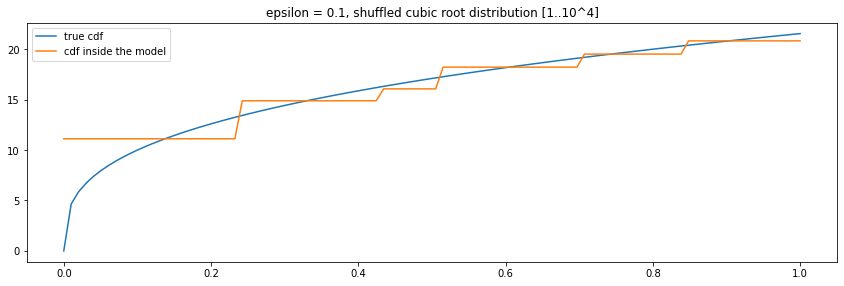

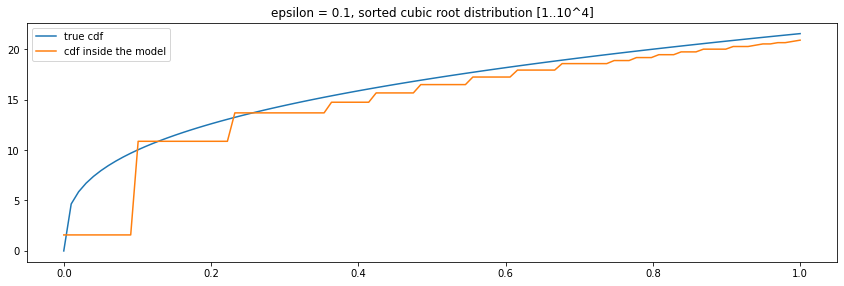

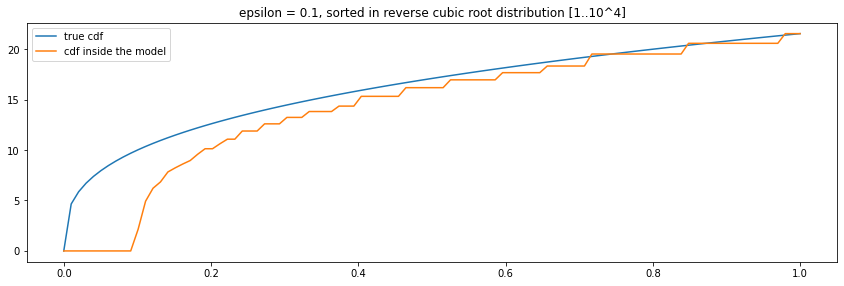

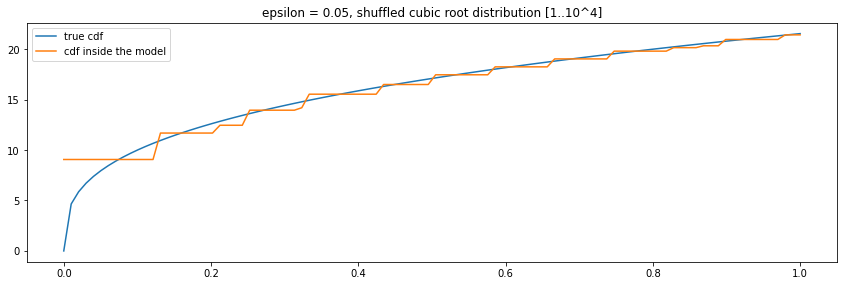

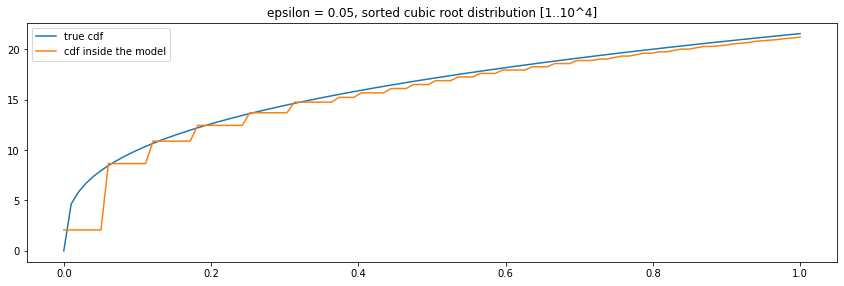

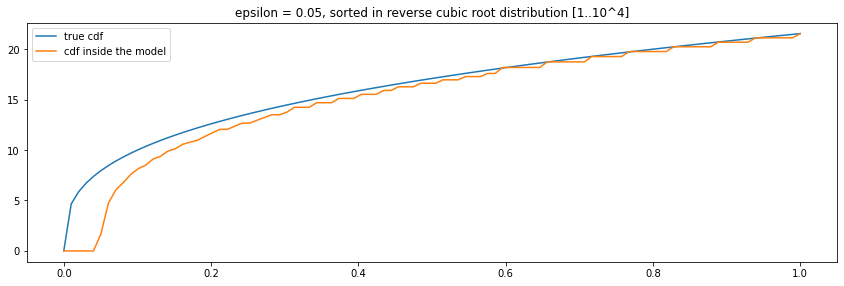

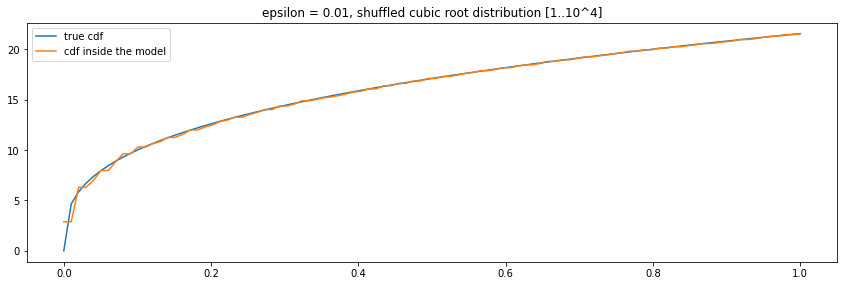

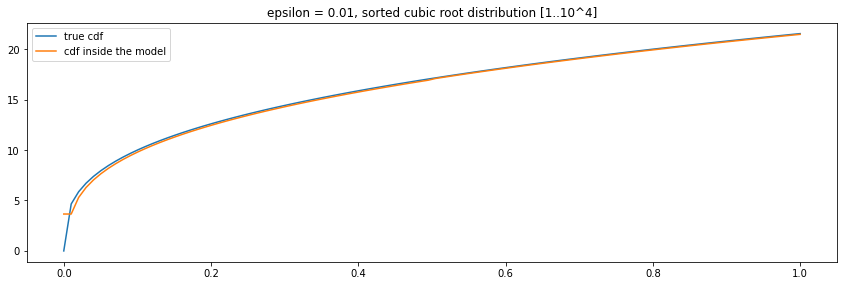

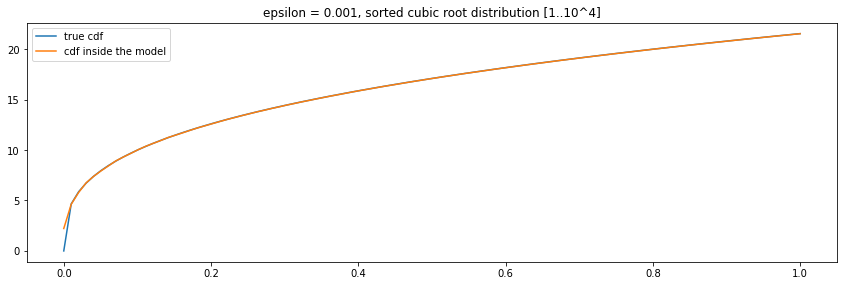

In [306]:
n = 4

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.1, dataset, f'shuffled cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
do(0.1, dataset, f'sorted cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])[::-1]
do(0.1, dataset, f'sorted in reverse cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.05, dataset, f'shuffled cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
do(0.05, dataset, f'sorted cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])[::-1]
do(0.05, dataset, f'sorted in reverse cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
np.random.shuffle(dataset)
do(0.01, dataset, f'shuffled cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
do(0.01, dataset, f'sorted cubic root distribution [1..10^{n}]')

dataset = np.array([np.cbrt(x) for x in range(0, 10**n)])
do(0.001, dataset, f'sorted cubic root distribution [1..10^{n}]')

### The theory holds for this distributions as well!

# 3. Points for improvement

In tearms of stability and following the algorithm from the paper, my code is working fine

In term of speed, for the dataset of size 10^5 and epsilon = 0.01, it takes ~5.5 second. I dont know if it is a lot

In [332]:
from time import time
dataset = np.array(range(0, 10**5))
np.random.shuffle(dataset)
begin = time()
GK01(0.01).add_all(dataset)
print(time() - begin)

5.57426905632019


Also the paper doesn't describe the optimal way to find bands and children of a node, so my implementation may not be optimal

If it makes sense, I included the profiler results

The model spends decent amount of time calculating bands

In [200]:
import cProfile, pstats, io
from pstats import SortKey
from contextlib import contextmanager
@contextmanager
def profiler():
    pr = cProfile.Profile()
    pr.enable()
    yield
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())

The most important column is "cumtime"

In [220]:
dataset = np.array(range(0, 10**6))
np.random.shuffle(dataset)
with profiler():
    GK01(0.05).add_all(dataset)

         51983767 function calls in 32.525 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.349    0.349   32.525   32.525 /tmp/ipykernel_146/3720528808.py:20(add_all)
  1000000    0.926    0.000   32.175    0.000 /tmp/ipykernel_146/3720528808.py:26(add)
  1000000    7.503    0.000   15.943    0.000 /tmp/ipykernel_146/3720528808.py:56(_insert)
   100000    3.690    0.000   15.224    0.000 /tmp/ipykernel_146/3720528808.py:74(_compress)
  6673526    1.936    0.000    8.433    0.000 /tmp/ipykernel_146/3720528808.py:106(_band)
   807159    6.497    0.000    6.497    0.000 /tmp/ipykernel_146/3720528808.py:114(_band2)
 18350837    4.403    0.000    4.403    0.000 <string>:2(__lt__)
  8750708    2.183    0.000    2.183    0.000 <string>:2(__le__)
  1858870    0.989    0.000    1.429    0.000 /tmp/ipykernel_146/3720528808.py:78(find_children)
  1858870    0.767    0.000    1.232    0.000 {built-in method builtins.su